# Zooplankton and Phytoplankton biomass sensitivity tests

In [151]:
%matplotlib inline
import warnings
warnings.simplefilter("ignore") # Silence warnings
import hvplot.xarray
import xarray as xr
import cartopy.crs as ccrs

import geoviews as gv
import holoviews as hv
import numpy as np
import math
from matplotlib.pyplot import figure

# MatPlotlib

import matplotlib.pyplot as plt
from matplotlib import pylab

# Scientific libraries
from numpy import arange,array,ones
from scipy import stats

import seaborn as sns
import scipy.io as sio

import numpy.ma as ma
from netCDF4 import Dataset as NetCDFFile
import glob
import pylab 
from copy import deepcopy
import pandas as pd
import os
import matplotlib.gridspec as gridspec
import matplotlib
import cartopy
import matplotlib.colors as colors
import cmocean
from scipy import stats
from scipy.stats import gaussian_kde

| Sensitivity Run | parameter changed    | Set Value          | Changed Value | Low/High |
|-----------|----------------------------|-------------------|-----------------------|-------|
| `s1`      | $\alpha_{PI}$      | -0.15 (phyto), -0.12 (diatoms) | -0.1125 (phyto), -0.09 (diatoms)| Low |
| `s2`      | $\alpha_{PI}$      | -0.15 (phyto), -0.12 (diatoms) | -0.1875 (phyto), -0.15 (diatoms)| High |
| `s3`      | k$_{NO_3}$         | 0.3 |0.24| Low|
| `s4`      | k$_{NO_3}$         | 0.3 |0.45 | High|
| `s5`      | m$_z$ | -0.25 |-0.375  | Low |                      
| `s6`      | m$_z$ | -0.25 |-0.125  | High  |                      
| `s7`      | $\mu_z$ | -0.25 |-0.375  | Low |                     
| `s8`      | $\mu_z$ | -0.25 |-0.125   | High |                     
| `s9`      | k$_m$                      | 1.1|1.65   | High |                     
| `s10`     | k$_m$                      | 1.1|0.55  | Low |

### For $\alpha_{PI}$ the varaibility is ~25% coming from Edwards et al. 2015 values, k$_N$ high and low values come from Edwards et al. 2012, and the rest have a variability of ~50%

In [152]:
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

In [153]:
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        if clip is None:
            clip = self.clip

        result, is_scalar = self.process_value(value)

        self.autoscale_None(result)
        vmin, vmax, midpoint = self.vmin, self.vmax, self.midpoint

        if not (vmin < midpoint < vmax):
            raise ValueError("midpoint must be between maxvalue and minvalue.")
        elif vmin == vmax:
            result.fill(0) # Or should it be all masked? Or 0.5?
        elif vmin > vmax:
            raise ValueError("maxvalue must be bigger than minvalue")
        else:
            vmin = float(vmin)
            vmax = float(vmax)
            if clip:
                mask = np.ma.getmask(result)
                result = np.ma.array(np.clip(result.filled(vmax), vmin, vmax),
                                  mask=mask)

            # ma division is very slow; we can take a shortcut
            resdat = result.data

            #First scale to -1 to 1 range, than to from 0 to 1.
            resdat -= midpoint
            resdat[resdat>0] /= abs(vmax - midpoint)
            resdat[resdat<0] /= abs(vmin - midpoint)

            resdat /= 2.
            resdat += 0.5
            result = np.ma.array(resdat, mask=result.mask, copy=False)

        if is_scalar:
            result = result[0]
        return result


In [154]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,np.min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8

    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

In [155]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

### Load and pre-process

In [156]:
print('What is the low_sensitivity_file')
low_sensitivity_file = input('')

print('What is the high_sensitivity_file')
high_sensitivity_file = input('')

What is the low_sensitivity_file


 s9


What is the high_sensitivity_file


 s10


## See if you can upload from campaign

File names: 

    * GNG595_10yrclim_1958-1968_1stCycle.nc
    * GNG595_s10_10yrclim_1958-1968_1stCycle.nc
    * GNG595_s1_10yrclim_1958-1968_1stCycle.nc
    * GNG595_s2_10yrclim_1958-1968_1stCycle.nc
    * GNG595_s3_10yrclim_1958-1968_1stCycle.nc
    * GNG595_s4_10yrclim_1958-1968_1stCycle.nc
    * GNG595_s5_10yrclim_1958-1968_1stCycle.nc
    * GNG595_s6_10yrclim_1958-1968_1stCycle.nc
    * GNG595_s7_10yrclim_1958-1968_1stCycle.nc
    * GNG595_s8_10yrclim_1958-1968_1stCycle.nc
    * GNG595_s9_10yrclim_1958-1968_1stCycle.nc
    

In [157]:
campaign_path = '/glade/campaign/cesm/development/bgcwg/projects/marbl-spectra/GNG595_Sensitivity_Cases'
high_sens = 'GNG595_'+high_sensitivity_file+'_10yrclim_1958-1968_1stCycle.nc'
low_sens = 'GNG595_'+low_sensitivity_file+'_10yrclim_1958-1968_1stCycle.nc'
nl_refcase = 'GNG595_10yrclim_1958-1968_1stCycle.nc'

In [158]:
ds= xr.open_mfdataset(''+campaign_path+'/'+nl_refcase+'')
ds_low= xr.open_mfdataset(''+campaign_path+'/'+low_sens+'')
ds_high= xr.open_mfdataset(''+campaign_path+'/'+high_sens+'')

low_sens = 'g.e21.G1850ECOIAF.t62_g17.marbl0_33.GNG595_'+low_sensitivity_file
high_sens = 'g.e21.G1850ECOIAF.t62_g17.marbl0_33.GNG595_'+high_sensitivity_file
nl_refcase = 'g.e21.G1850ECOIAF.t62_g17.marbl0_33.GNG595'

# This is how I can select files of just one year. 
# files = sorted(glob.glob('/glade/scratch/gabyn/archive/%s/ocn/hist/%s.pop.h.00%d*.nc'%(nl_refcase,nl_refcase,10)))

# And here, I can select them for all years from 10 to 20. 
files_base = sorted(glob.glob('/glade/scratch/gabyn/archive/%s/ocn/hist/%s.pop.h.00[12]*.nc'%(nl_refcase,nl_refcase)))
files_s_low = sorted(glob.glob('/glade/scratch/gabyn/archive/%s/ocn/hist/%s.pop.h.00[12]*.nc'%(low_sens,low_sens)))
files_s_high = sorted(glob.glob('/glade/scratch/gabyn/archive/%s/ocn/hist/%s.pop.h.00[12]*.nc'%(high_sens,high_sens)))

ds= xr.open_mfdataset(files_base,combine='by_coords')

ds_low= xr.open_mfdataset(files_s_low,combine='by_coords')

ds_high= xr.open_mfdataset(files_s_high,combine='by_coords')

## primary production

In [159]:
total_npp = ds.photoC_TOT.sum(dim='z_t_150m') * 10 #integrate over depth #mmol m-2 s-1
total_npp = (total_npp * ds.TAREA / 1e4).sum(dim=['nlat','nlon']) # mmol s-1
total_npp = total_npp.mean(dim='record') * (60*60*24*365) # mmol y-1
total_npp = total_npp * 12.011 / 1e3

print(total_npp.values)

[5.20145817e+16]


In [160]:
total_npp_low = ds_low.photoC_TOT.sum(dim='z_t_150m') * 10 #integrate over depth #mmol m-2 s-1
total_npp_low = (total_npp_low * ds_low.TAREA / 1e4).sum(dim=['nlat','nlon']) # mmol s-1
total_npp_low = total_npp_low.mean(dim='record') * (60*60*24*365) # mmol y-1
total_npp_low = total_npp_low * 12.011 / 1e3

print(total_npp_low.values)

[5.08635126e+16]


In [161]:
total_npp_high = ds_high.photoC_TOT.sum(dim='z_t_150m') * 10 #integrate over depth #mmol m-2 s-1
total_npp_high = (total_npp_high * ds_high.TAREA / 1e4).sum(dim=['nlat','nlon']) # mmol s-1
total_npp_high = total_npp_high.mean(dim='record') * (60*60*24*365) # mmol y-1
total_npp_high = total_npp_high * 12.011 / 1e3

print(total_npp_high.values)

[4.38048117e+16]


### POC flux

In [162]:
POC_flux = ds.POC_FLUX_IN.isel(z_t=10) / 1e2 # mmol m-2 s-1
POC_flux = (POC_flux * ds.TAREA / 1e4).sum(dim=['nlat','nlon']) # mmol s-1
POC_flux = POC_flux.mean(dim='record') * (60*60*24*365) # mmol y-1
POC_flux = POC_flux * 1000000 #nmol y-1

print(np.format_float_scientific(POC_flux.values,2))

5.77e+23


In [163]:
POC_flux_low = ds_low.POC_FLUX_IN.isel(z_t=10) / 1e2 # mmol m-2 s-1
POC_flux_low = (POC_flux_low * ds_low.TAREA / 1e4).sum(dim=['nlat','nlon']) # mmol s-1
POC_flux_low = POC_flux_low.mean(dim='record') * (60*60*24*365) # mmol y-1
POC_flux_low = POC_flux_low * 1000000 #nmol y-1

print(np.format_float_scientific(POC_flux_low.values,2))

6.31e+23


In [164]:
POC_flux_high = ds_high.POC_FLUX_IN.isel(z_t=10) / 1e2 # mmol m-2 s-1
POC_flux_high = (POC_flux_high * ds_high.TAREA / 1e4).sum(dim=['nlat','nlon']) # mmol s-1
POC_flux_high = POC_flux_high.mean(dim='record') * (60*60*24*365) # mmol y-1
POC_flux_high = POC_flux_high * 1000000 #nmol y-1

print(np.format_float_scientific(POC_flux_high.values,2))

5.29e+23


# Phytoplankton

In [165]:
phyto_names = ['pp','diaz','mp1','diat1','mp2','diat2','mp3','diat3','mp4']
phyto_vars = [''+v+'C' for v in phyto_names] # mmol C /m^3
phytoC_ind = xr.concat([ds[v] for v in phyto_vars], dim='var')
phytoC_ind_zint = phytoC_ind.sum(dim='z_t_150m') * 10 #integrate over depth #mmol C m-2

### Add phytoplankton biomass threshold anything below 1.06 mmol C m-2 make zero 

In [166]:
mask_less_than_zero = phytoC_ind_zint.values < 1.065 # find all that are less than zero 
new_phytoC_ind_zint = phytoC_ind_zint.values
new_phytoC_ind_zint[mask_less_than_zero] = 0 # Make these values zero

In [167]:
phyto_names = ['pp','diaz','mp1','diat1','mp2','diat2','mp3','diat3','mp4']
phyto_vars = [''+v+'C' for v in phyto_names] # mmol C /m^3

phytoC_ind_low = xr.concat([ds_low[v] for v in phyto_vars], dim='var')
phytoC_ind_zint_low = phytoC_ind_low.sum(dim='z_t_150m') * 10 #integrate over depth #mmol C m-2

phytoC_ind_high = xr.concat([ds_high[v] for v in phyto_vars], dim='var')
phytoC_ind_zint_high = phytoC_ind_high.sum(dim='z_t_150m') * 10 #integrate over depth #mmol C m-2

In [168]:
mask_less_than_zero_low = phytoC_ind_zint_low.values < 1.065 # find all that are less than zero 
new_phytoC_ind_zint_low = phytoC_ind_zint_low.values
new_phytoC_ind_zint_low[mask_less_than_zero_low] = 0 # Make these values zero

mask_less_than_zero_high = phytoC_ind_zint_high.values < 1.065 # find all that are less than zero 
new_phytoC_ind_zint_high = phytoC_ind_zint_high.values
new_phytoC_ind_zint_high[mask_less_than_zero_high] = 0 # Make these values zero

## Zooplankton 

In [169]:
zoo_names = ['zoo1','zoo2','zoo3','zoo4','zoo5','zoo6']
zoo_vars = [''+v+'C' for v in zoo_names] # mmol C /m^3
zoo_ind = xr.concat([ds[v] for v in zoo_vars], dim='var')
zoo_ind_zint = zoo_ind.sum(dim='z_t_150m') * 10 #integrate over depth #mmol C m-2

zoo_ind_low = xr.concat([ds_low[v] for v in zoo_vars], dim='var')
zoo_ind_zint_low = zoo_ind_low.sum(dim='z_t_150m') * 10 #integrate over depth #mmol C m-2

zoo_ind_high = xr.concat([ds_high[v] for v in zoo_vars], dim='var')
zoo_ind_zint_high = zoo_ind_high.sum(dim='z_t_150m') * 10 #integrate over depth #mmol C m-2

In [170]:
mask_less_than_zero = zoo_ind_zint.values < 1.065 # find all that are less than zero 
new_zoo_ind_zint = zoo_ind_zint.values
new_zoo_ind_zint[mask_less_than_zero] = 0 # Make these values zero

mask_less_than_zero_low = zoo_ind_zint_low.values < 1.065 # find all that are less than zero 
new_zoo_ind_zint_low = zoo_ind_zint_low.values
new_zoo_ind_zint_low[mask_less_than_zero_low] = 0 # Make these values zero

mask_less_than_zero_high = zoo_ind_zint_high.values < 1.065 # find all that are less than zero 
new_zoo_ind_zint_high = zoo_ind_zint_high.values
new_zoo_ind_zint_high[mask_less_than_zero_high] = 0 # Make these values zero

In [171]:
new_zoo_ind_zint.shape

(6, 12, 1, 384, 320)

### Phytoplankton and zooplankton biomass and difference figures

In [172]:
x, y, smphyto = adjust_pop_grid(ds.TLONG, ds.TLAT, np.mean(new_phytoC_ind_zint[0:3,:,0,:,:],axis=(0,1)))
x, y, smphyto_low = adjust_pop_grid(ds.TLONG, ds.TLAT, np.mean(new_phytoC_ind_zint_low[0:3,:,0,:,:],axis=(0,1)))
x, y, smphyto_high = adjust_pop_grid(ds.TLONG, ds.TLAT, np.mean(new_phytoC_ind_zint_high[0:3,:,0,:,:],axis=(0,1)))

In [173]:
x, y, lgphyto = adjust_pop_grid(ds.TLONG, ds.TLAT, np.mean(new_phytoC_ind_zint[3:9,:,0,:,:],axis=(0,1)))
x, y, lgphyto_low = adjust_pop_grid(ds.TLONG, ds.TLAT, np.mean(new_phytoC_ind_zint_low[3:9,:,0,:,:],axis=(0,1)))
x, y, lgphyto_high = adjust_pop_grid(ds.TLONG, ds.TLAT, np.mean(new_phytoC_ind_zint_high[3:9,:,0,:,:],axis=(0,1)))

In [174]:
x, y, microzoo = adjust_pop_grid(ds.TLONG, ds.TLAT, np.mean(new_zoo_ind_zint[0:2,:,0,:,:],axis=(0,1)))
x, y, microzoo_low = adjust_pop_grid(ds.TLONG, ds.TLAT, np.mean(new_zoo_ind_zint_low[0:2,:,0,:,:],axis=(0,1)))
x, y, microzoo_high = adjust_pop_grid(ds.TLONG, ds.TLAT, np.mean(new_zoo_ind_zint_high[0:2,:,0,:,:],axis=(0,1)))

In [175]:
x, y, mesozoo = adjust_pop_grid(ds.TLONG, ds.TLAT, np.mean(new_zoo_ind_zint[2:6,:,0,:,:],axis=(0,1)))
x, y, mesozoo_low = adjust_pop_grid(ds.TLONG, ds.TLAT, np.mean(new_zoo_ind_zint_low[2:6,:,0,:,:],axis=(0,1)))
x, y, mesozoo_high = adjust_pop_grid(ds.TLONG, ds.TLAT, np.mean(new_zoo_ind_zint_high[2:6,:,0,:,:],axis=(0,1)))

## Calculate bias and RMSE

In [176]:
#small phytoplankton
smphyto_low_rmse = (np.nanmean((smphyto_low- smphyto)**2))**0.5
smphyto_high_rmse = (np.nanmean((smphyto_high- smphyto)**2))**0.5

# large phytoplankton
lgphyto_low_rmse = (np.nanmean((lgphyto_low-lgphyto)**2))**0.5
lgphyto_high_rmse = (np.nanmean((lgphyto_high - lgphyto)**2))**0.5

# microzooplankton
microzoo_low_rmse = (np.nanmean((microzoo_low-microzoo)**2))**0.5
microzoo_high_rmse = (np.nanmean((microzoo_high-microzoo)**2))**0.5

# mesozooplankton
mesozoo_low_rmse = (np.nanmean((mesozoo_low-mesozoo)**2))**0.5
mesozoo_high_rmse = (np.nanmean((mesozoo_high-mesozoo)**2))**0.5

In [177]:
smphyto_low_bias = np.nanmean(smphyto_low-smphyto)
smphyto_high_bias = np.nanmean(smphyto_high-smphyto)

lgphyto_low_bias = np.nanmean(lgphyto_low-lgphyto)
lgphyto_high_bias = np.nanmean(lgphyto_high-lgphyto)

microzoo_low_bias = np.nanmean(microzoo_low-microzoo)
microzoo_high_bias = np.nanmean(microzoo_high-microzoo)

mesozoo_low_bias = np.nanmean(mesozoo_low-mesozoo)
mesozoo_high_bias = np.nanmean(mesozoo_high-mesozoo)

In [178]:
smphyto_low_rmse

6.086733803909795

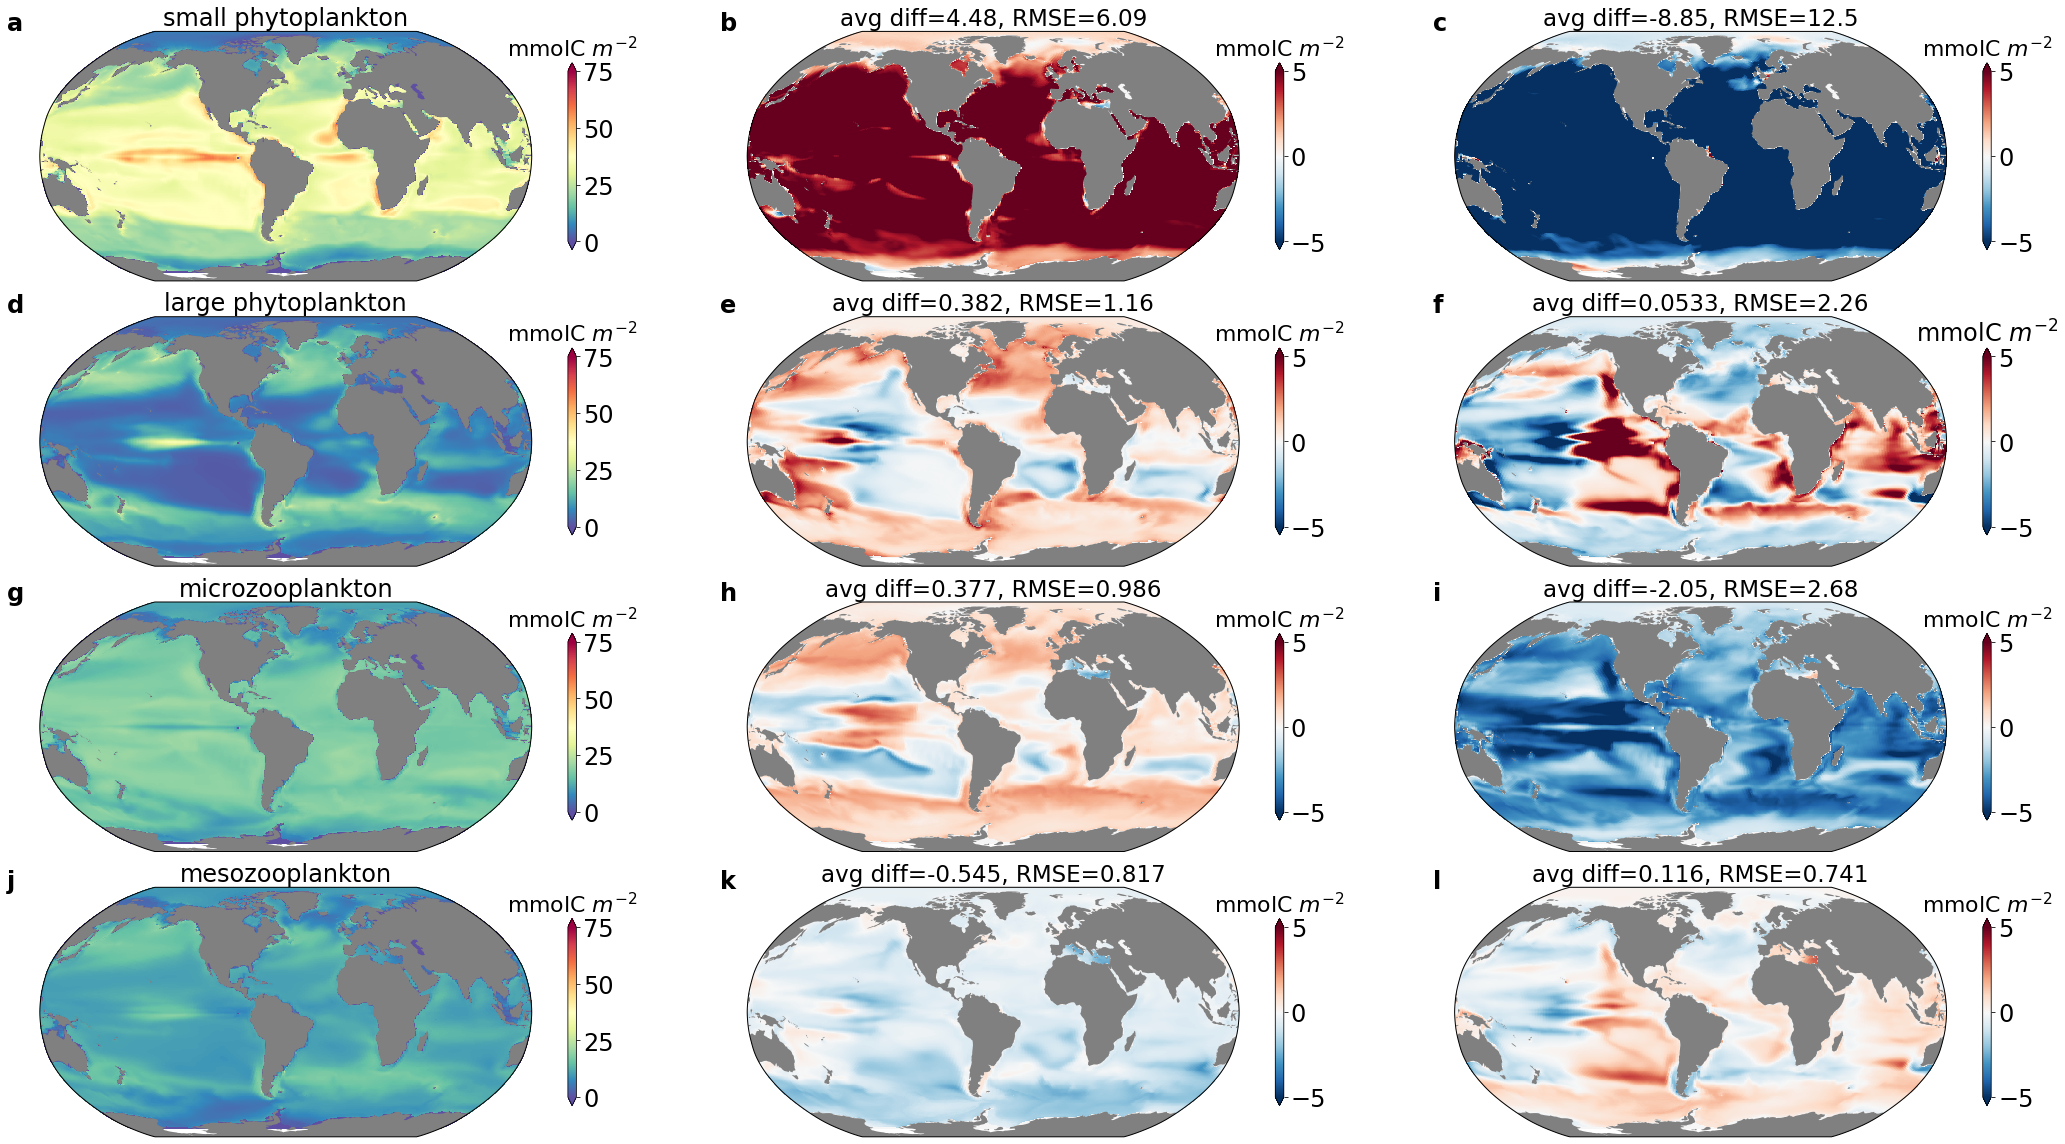

In [179]:
import matplotlib.colors as colors
fig = plt.figure(figsize=(30, 16))
#lev = np.arange(0, 2.1, 0.1)
#norm = colors.DivergingNorm(vmin=lev[0], vmax=lev[-1], vcenter=1)
ax = fig.add_subplot(4, 3, 1, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.pcolormesh(x, y, smphyto, cmap='Spectral_r', vmin=0,vmax=75,transform=ccrs.PlateCarree())
ax.set_global()
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('small phytoplankton', fontsize = 24)
cbar = plt.colorbar(cf,shrink =0.75,extend = 'both')
cbar.ax.set_title('mmolC $m^{-2}$', fontsize = 22)
fig.text(0.03, 0.97, 'a',fontsize=24, fontweight='bold')
cbar.ax.tick_params(labelsize=24)

ax = fig.add_subplot(4, 3, 2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_global()
cf = ax.pcolormesh(x, y, -smphyto+smphyto_low, cmap='RdBu_r', vmin=-5,vmax=5,transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cbar = plt.colorbar(cf,shrink =0.75,extend = 'both')
cbar.ax.set_title('mmolC $m^{-2}$', fontsize = 22)
fig.text(0.36, 0.97, 'b',fontsize=24, fontweight='bold')
ax.set_title('avg diff='+'{0:1.3g}'.format(smphyto_low_bias)+', RMSE='+'{0:1.3g}'.format(smphyto_low_rmse)+'',fontsize=23)
cbar.ax.tick_params(labelsize=24)

ax = fig.add_subplot(4, 3, 3, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_global()
cf = ax.pcolormesh(x, y, -smphyto+smphyto_high, cmap='RdBu_r', vmin=-5,vmax=5,transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cbar = plt.colorbar(cf,shrink =0.75,extend = 'both')
cbar.ax.set_title('mmolC $m^{-2}$', fontsize = 22)
fig.text(0.69, 0.97, 'c',fontsize=24, fontweight='bold')
ax.set_title('avg diff='+'{0:1.3g}'.format(smphyto_high_bias)+', RMSE='+'{0:1.3g}'.format(smphyto_high_rmse)+'',fontsize=23)
cbar.ax.tick_params(labelsize=24)

ax = fig.add_subplot(4, 3, 4, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_global()
cf = ax.pcolormesh(x, y, lgphyto, cmap='Spectral_r',vmin=0,vmax=75,transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('large phytoplankton', fontsize = 24)
cbar = plt.colorbar(cf,shrink =0.75,extend = 'both')
cbar.ax.set_title('mmolC $m^{-2}$', fontsize = 22)
fig.text(0.03, 0.725, 'd',fontsize=24, fontweight='bold')
cbar.ax.tick_params(labelsize=24)

ax = fig.add_subplot(4, 3, 5, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_global()
cf = ax.pcolormesh(x, y, -lgphyto+lgphyto_low, cmap='RdBu_r',  vmin=-5,vmax=5,transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cbar = plt.colorbar(cf,shrink =0.75,extend = 'both')
cbar.ax.set_title('mmolC $m^{-2}$', fontsize = 22)
fig.text(0.36, 0.725, 'e',fontsize=24, fontweight='bold')
ax.set_title('avg diff='+'{0:1.3g}'.format(lgphyto_low_bias)+', RMSE='+'{0:1.3g}'.format(lgphyto_low_rmse)+'',fontsize=23)
cbar.ax.tick_params(labelsize=24)

ax = fig.add_subplot(4, 3, 6, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_global()
cf = ax.pcolormesh(x, y, -lgphyto+lgphyto_high, cmap='RdBu_r',  vmin=-5,vmax=5,transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cbar = plt.colorbar(cf,shrink =0.75,extend = 'both')
cbar.ax.set_title('mmolC $m^{-2}$', fontsize = 24)
fig.text(0.69, 0.725, 'f',fontsize=24, fontweight='bold')
ax.set_title('avg diff='+'{0:1.3g}'.format(lgphyto_high_bias)+', RMSE='+'{0:1.3g}'.format(lgphyto_high_rmse)+'',fontsize=23)
cbar.ax.tick_params(labelsize=24)

ax = fig.add_subplot(4, 3, 7, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_global()
cf = ax.pcolormesh(x, y, microzoo, cmap='Spectral_r', vmin=0,vmax=75,transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('microzooplankton', fontsize = 24)
cbar = plt.colorbar(cf,shrink =0.75,extend = 'both')
cbar.ax.set_title('mmolC $m^{-2}$', fontsize = 22)
fig.text(0.03, 0.475, 'g',fontsize=24, fontweight='bold')
cbar.ax.tick_params(labelsize=24)

ax = fig.add_subplot(4, 3, 8, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_global()
cf = ax.pcolormesh(x, y, -microzoo+microzoo_low, cmap='RdBu_r', vmin=-5,vmax=5,transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cbar = plt.colorbar(cf,shrink =0.75,extend = 'both')
cbar.ax.set_title('mmolC $m^{-2}$', fontsize =  22)
fig.text(0.36, 0.475, 'h',fontsize=24, fontweight='bold')
ax.set_title('avg diff='+'{0:1.3g}'.format(microzoo_low_bias)+', RMSE='+'{0:1.3g}'.format(microzoo_low_rmse)+'',fontsize=23)
cbar.ax.tick_params(labelsize=24)

ax = fig.add_subplot(4, 3, 9, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_global()
cf = ax.pcolormesh(x, y, -microzoo+microzoo_high, cmap='RdBu_r', vmin=-5,vmax=5,transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cbar = plt.colorbar(cf,shrink =0.75,extend = 'both')
cbar.ax.set_title('mmolC $m^{-2}$', fontsize = 22)
fig.text(0.69, 0.475, 'i',fontsize=24, fontweight='bold')
ax.set_title('avg diff='+'{0:1.3g}'.format(microzoo_high_bias)+', RMSE='+'{0:1.3g}'.format(microzoo_high_rmse)+'',fontsize=23)
cbar.ax.tick_params(labelsize=24)

ax = fig.add_subplot(4, 3, 10, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_global()
cf = ax.pcolormesh(x, y, mesozoo, cmap='Spectral_r',vmin=0,vmax=75,transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
ax.set_title('mesozooplankton', fontsize = 24)
cbar = plt.colorbar(cf,shrink =0.75,extend = 'both')
cbar.ax.set_title('mmolC $m^{-2}$', fontsize = 22)
fig.text(0.03, 0.225, 'j',fontsize=24, fontweight='bold')
cbar.ax.tick_params(labelsize=24)

ax = fig.add_subplot(4, 3, 11, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_global()
cf = ax.pcolormesh(x, y, -mesozoo+mesozoo_low, cmap='RdBu_r', vmin=-5,vmax=5,transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cbar = plt.colorbar(cf,shrink =0.75,extend = 'both')
cbar.ax.set_title('mmolC $m^{-2}$', fontsize = 22)
fig.text(0.36, 0.225, 'k',fontsize=24, fontweight='bold')
ax.set_title('avg diff='+'{0:1.3g}'.format(mesozoo_low_bias)+', RMSE='+'{0:1.3g}'.format(mesozoo_low_rmse)+'',fontsize=23)
cbar.ax.tick_params(labelsize=24)

ax = fig.add_subplot(4, 3, 12, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_global()
cf = ax.pcolormesh(x, y, -mesozoo+mesozoo_high, cmap='RdBu_r', vmin=-5,vmax=5, transform=ccrs.PlateCarree())
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='gray'))
cbar = plt.colorbar(cf,shrink =0.75,extend = 'both')
cbar.ax.set_title('mmolC $m^{-2}$', fontsize = 22)
fig.text(0.69, 0.225, 'l',fontsize=24, fontweight='bold')
ax.set_title('avg diff='+'{0:1.3g}'.format(mesozoo_high_bias)+', RMSE='+'{0:1.3g}'.format(mesozoo_high_rmse)+'',fontsize=23)
cbar.ax.tick_params(labelsize=24)
fig.tight_layout()
plt.show()
#fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/GNG595/phyto_biomass_'+low_sensitivity_file+'_vs_'+high_sensitivity_file+'_test_2.png',dpi=600, bbox_inches='tight')